# VLSI - SAT Model

#### Definition of the problem
**Input**: A set *R = {r1, . . . , rn}* of *n* rectangles. Each rectangle
*ri ∈ R* has a width *w_i* and a height *h_i* *(w_i, h_i ∈ N)*. A Strip of
width *W ∈ N*.

**Constraints**: Each rectangle cannot overlap with the others
and the edges of the strip and must be parallel to the horizontal
and the vertical axis.

**Question**: What is the minimum height such that the set of
rectangles can be packed in the given strip?

In [ ]:
!pip3 install z3-solver

In [1]:
import os,sys,inspect,getopt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from z3 import *
import math
import pandas as pd
import seaborn as sns
import csv

currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import utils

### Useful functions 

In [2]:
def large_rectangles(w_i, w_j, h_i, h_j, W, H):
    if w_i + w_j <= W and h_i + h_j <= H:
        return False
    elif w_i + w_j > W and h_i + h_j <= H:
        return "W"
    elif w_i + w_j <= W and h_i + h_j > H:
        return "H"

def same_rectangles(w1,w2,h1,h2):
    if w1 == w2 and h1 == h2:
        return True
    else:
        return False

def largest_rectangle(idx, max_idx):
    if idx == max_idx:
        return True
    else:
        return False
    
def no_overlap(W, H, widths, heights, i, j, flip, px, py, lr, ud):            
    dim1,dim2=(widths[i],heights[i]) if not flip else (heights[i],widths[i])
    cts=[]
    
    if lr:
        # lr(r_i,r_j)-> x_j > w_i
        cts.append(Or(
                Not(lr[i][j]),
                Not(px[j][dim1-1]),
            )) 

        for e in range(0,W-dim1):
            cts.append(Or(
                Not(lr[i][j]),
                Not(px[j][e+dim1]),
                px[i][e]
            ))

    if ud:
        # ud(r_i,r_j)-> y_j > h_i
        cts.append(Or(
                Not(ud[i][j]),
                Not(py[j][dim2-1])
            ))

        for f in range(0,H-dim2):
            cts.append(Or(
                Not(ud[i][j]),
                Not(py[j][f+dim2]),
                py[i][f]
            ))

    return cts

def getCoords(vars_dict, W, H, n, widths, heights, rot = False):
    x_sol = []
    y_sol = [] 
    w=[]
    h=[]
                
    for i in range(n):
        if rot:
            if vars_dict[f"f{i+1}"]:  
                w.append(heights[i])
                h.append(widths[i])
            else:
                w.append(widths[i])
                h.append(heights[i])
                
        x = 0
        while x < W:
            try:
                if vars_dict[f"px{i+1}_{x}"]:                
                    x_sol.append(x)
                    break
            except:
                pass
            x += 1
        y = 0
        
        while y < H:
            try:
                if vars_dict[f"py{i+1}_{y}"]:                
                    y_sol.append(y)
                    break
            except:
                pass
            y += 1
        
    return x_sol, y_sol, w, h

### Model - Order Encoding

[1] https://web.telegram.org/cd003ba1-9c37-41f3-9be7-dceeb848b5e2

[2] https://sourceforge.net/p/potassco/mailman/attachment/1323943585.4102.431.camel@white.sevalidation.com/1/

In [15]:
'''
 # SEARCH SPACE REDUCTION 
    1. Large Rectangles (LR): 
        Reducing the possibilities for placing large rectangles.
        For each rectangle ri and r j, if wi + w j > W we can not pack
        these rectangles in the horizontal direction. We therefore
        modify non-overlapping constraints.
        This technique is also applicable for the vertical direction.

    2. Same Rectangles (SR):
        For each rectangle ri and r j, if (wi, hi) = (w j, h j) we can 
        fix the positional relation of these rectangles. 
        
    3. Largest Rectangle (LS): 
        Reducing the domain for the largest rectangle.
        With breaking symmetries, we can reduce the domain of
        largest rectangle.

                    D(x_i) = {a ∈ N | 0 ≤ a ≤ floor((W − w_i)/2)}
                    D(y_i) = {a ∈ N | 0 ≤ a ≤ floor((H − h_i)/2)}
'''

def vlsi_sat(instance):
    ''' VARIABLES '''

    n = instance['n']
    W = instance['w']
    widths  = [i[0] for i in instance['dim']]
    heights = [i[1] for i in instance['dim']]
    largest_idx = [w*h for w,h in zip(widths,heights)].index(max([w*h for w,h in\
                                                                        zip(widths,heights)]))   
    tot_area=sum([w*h for w,h in zip(widths,heights)])
    model = None
    
    naiveSolution = utils.computeNaiveSolution(instance)
    
    if not naiveSolution:
        return None,0.0

    lb = int(math.ceil(tot_area/W))
    ub = naiveSolution[0][1]+1
    
    print("\n>Starting Lower Bound:", lb)
    print(">Starting Upper Bound:", ub)
    
    H = int((lb+ub)/2)
    
    s_time = time.time()
    while (lb < ub):
        s = Solver()
        
        ''' SOLVER WITH 5 MINUTES TIMEOUT'''
        s.set("timeout", int((300-(time.time()-s_time))*1000))
        
        if (time.time() > s_time + 300):
            break
        else:
            print(f"\t>Trying H:{H}")
        
        '''
        ==================================================================
        Let x_i and y_i be integer variables such that the pair (x_i, y_i)
        represents the position of lower left coordinates of the rectangle
        ri in the strip.
        The domains of x_i and y_i are as folbows.
                            D(x_i) = {a ∈ N | 0 ≤ a ≤ W − w_i}
                            D(y_i) = {a ∈ N | 0 ≤ a ≤ H − h_i}
        ==================================================================
        Let r_i, r_j ∈ R(i != j) be two rectangles. We use two
        kinds of propositional variables: lr_i,j and ud_i,j.
        lr_i,j is true if r_i are placed at the left to the r_j.
        ud_i,j is true if r_i are placed at the downward to the r_j.

        ==================================================================
        For each rectangles r_i,r_j (i < j), we have the non-overlapping
        constraints:
                            lr_i,j ∨ lr_j,i ∨ ud_i,j ∨ ud_j,i
                                ¬lr_i,j ∨ (x_i + w_i ≤ x_j)
                                ¬lr_j,i ∨ (x_j + w_j ≤ x_i)
                                ¬ud_i,j ∨ (y_i + h_i ≤ y_j)
                                ¬ud_j,i ∨ (y_j + h_j ≤ y_i)
        The parts between parentheses are encoded into SAT by using order
        encoding.
        '''
        px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        lr = [[Bool(f"lr_{i+1}_{j+1}") if j!=i else 0 for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)]

        # Exactly One constraint
        for i in range(n): 
            '''
            ==================================================================
            Order encoding is a generalization of the encoding method
            originally used by Crawford and Baker for Job-Shop
            Scheduling problems.
            It uses a different Boolean variable P_x,a representing x ≤ a
            for each integer variable x and integer value a.
            
            For each rectangle r_i, and integer e and f such that
            0 ≤ e ≤ W − wi and 0 ≤ f ≤ H − h_i, we have the 2-literal
            axiom clauses due to order encoding,
                                ¬ px_i,e ∨ px_i,e+1
                                ¬ py_i, f ∨ py_i, f +1
            ==================================================================
            '''            
            if largest_rectangle(i, largest_idx):
                s.add([px[i][e] for e in range(int((W-widths[i])/2),W)]) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                s.add([py[i][f] for f in range(int((H-heights[i])/2),H)]) # same for the y coordinate 
            else:
                s.add([px[i][e] for e in range(W-widths[i],W)]) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 
                s.add([py[i][f] for f in range(H-heights[i],H)]) # same for the y coordinate 
            
            s.add([Or(Not(px[i][e]),px[i][e+1]) for e in range(W-1)]) #x[i][j] implies x[i][j+1]
            s.add([Or(Not(py[i][f]),py[i][f+1]) for f in range(H-1)]) #y[i][j] implies y[i][j+1]

            for j in range(n):
                '''
                ==================================================================
                For each rectangles i,j (i < j), we have the non-overlapping
                constraints as the 4-literal clauses:
                                lr_i,j ∨ lr_j,i ∨ ud_i,j ∨ ud_j,i 
                                
                For each rectangles i, j (i < j), and integer e and f such that
                0 ≤ e < W − wi and 0 ≤ f < H − h j, we also have the
                non-overlapping constraints as the 3-literal clauses:
                                ¬lr_i,j ∨ px_i,e ∨ ¬px_j,e + w_i
                                ¬lr_j,i ∨ px_j,e ∨ ¬px_i,e + w_j
                                ¬ud_i,j ∨ py_i,f ∨ ¬py_j,f + h_i
                                ¬ud_j,i ∨ py_j,f ∨ ¬py_i,f + h_j
                ==================================================================
                '''
                if i<j:  
                    if large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == False:
                        if same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                            s.add(Or(lr[i][j],ud[i][j],ud[j][i]))

                            s.add(
                                *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,ud),
                                *no_overlap(W,H,widths,heights,j,i,False,px,py,False,ud)
                            )

                            s.add(Or(
                                    Not(ud[i][j]),
                                    lr[j][i]
                            ))
                        else:
                            if not largest_rectangle(j, largest_idx):
                                s.add(Or(lr[i][j],lr[j][i],ud[i][j],ud[j][i]))

                                s.add(
                                    *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,ud),
                                    *no_overlap(W,H,widths,heights,j,i,False,px,py,lr,ud)
                                )
                            else:
                                s.add(Or(lr[j][i],ud[i][j],ud[j][i]))

                                s.add(
                                    *no_overlap(W,H,widths,heights,i,j,False,px,py,False,ud),
                                    *no_overlap(W,H,widths,heights,j,i,False,px,py,lr,ud)
                                )
                    elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "W":
                        s.add(Or(ud[i][j],ud[j][i]))

                        s.add(
                            *no_overlap(W,H,widths,heights,i,j,False,px,py,False,ud),
                            *no_overlap(W,H,widths,heights,j,i,False,px,py,False,ud)
                        )

                    elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "H":
                        if same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                            s.add(lr[i][j])

                            s.add(
                                *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,False)
                            )

                            s.add(Or(
                                    Not(ud[i][j]),
                                    lr[j][i]
                            ))  
                        else:                            
                            s.add(Or(lr[i][j],lr[j][i]))

                            s.add(
                                *no_overlap(W,H,widths,heights,i,j,False,px,py,lr,False),
                                *no_overlap(W,H,widths,heights,j,i,False,px,py,lr,False)
                            )


        if s.check() == sat:
            if (time.time() - s_time <= 300):
                ub = H
                model = s.model()                   
            
            print(f'\t\t>SAT - ub: {ub}, {time.time() - s_time} s')
            
        else:
            lb = H + 1
            if (time.time() - s_time <= 300):
                print(f'\t\t>UNSAT - lb: {lb}, {time.time() - s_time} s')
                
            
        H =  int((lb+ub)/2)
        
        '''
        ==================================================================
        'Bisection Method':
            while lb < ub
                o := (lb + ub)/2;
                result := Ψ ∪ {ph_o};
                if result is SAT
                    then ub := o;
                    else lb := o + 1;
            end while
        ==================================================================
        '''
    
    e_time = time.time() - s_time
    
    if model == None:
        return None, e_time
    elif e_time > 300:
        variables = { str(d):model.evaluate(model[d]) for d in model }
        cx,cy,_,_ = getCoords(variables, W, ub, n, widths, heights)

        sol = [[W,ub]]+[[widths[i],heights[i],cx[i]+1,cy[i]+1]\
                    for i in range(min(len(cx),len(cy),len(widths),len(heights)))]
        
        return sol, e_time
    else:
        variables = { str(d):model.evaluate(model[d]) for d in model }
        cx,cy,_,_ = getCoords(variables, W, H, n, widths, heights)
        
        sol=[[W,H]]+[[widths[i],heights[i],cx[i]+1,cy[i]+1]\
                    for i in range(n)]
        
        return sol, e_time

Instance: n=4 w=8 dim=[[3, 3], [3, 5], [5, 3], [5, 5]]

>Starting Lower Bound: 8
>Starting Upper Bound: 9
	>Trying H:8
		>SAT - ub: 8, 0.039700984954833984 s


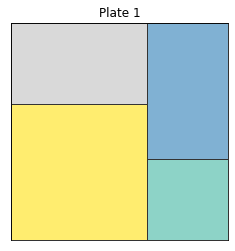

Instance[1] solved in 0.04 s, height: 8


Instance: n=5 w=9 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

>Starting Lower Bound: 9
>Starting Upper Bound: 10
	>Trying H:9
		>SAT - ub: 9, 0.05794358253479004 s


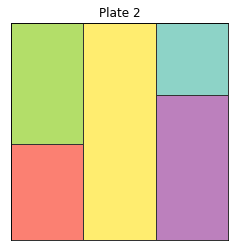

Instance[2] solved in 0.058 s, height: 9


Instance: n=6 w=10 dim=[[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

>Starting Lower Bound: 10
>Starting Upper Bound: 11
	>Trying H:10
		>SAT - ub: 10, 0.09100890159606934 s


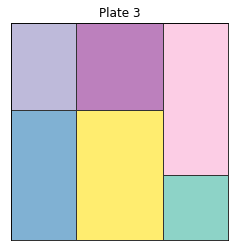

Instance[3] solved in 0.091 s, height: 10


Instance: n=7 w=11 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

>Starting Lower Bound: 11
>Starting Upper Bound: 13
	>Trying H:12
		>SAT - ub: 12, 0.14499878883361816 s
	>Trying H:11
		>SAT - ub: 11, 0.28803229331970215 s


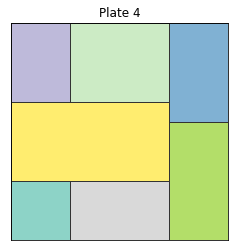

Instance[4] solved in 0.288 s, height: 11


Instance: n=8 w=12 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

>Starting Lower Bound: 12
>Starting Upper Bound: 15
	>Trying H:13
		>SAT - ub: 13, 0.2109994888305664 s
	>Trying H:12
		>SAT - ub: 12, 0.40903449058532715 s


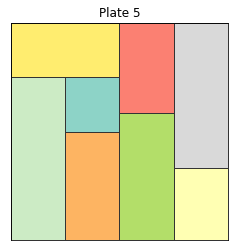

Instance[5] solved in 0.409 s, height: 12


Instance: n=9 w=13 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

>Starting Lower Bound: 13
>Starting Upper Bound: 16
	>Trying H:14
		>SAT - ub: 14, 0.32904553413391113 s
	>Trying H:13
		>SAT - ub: 13, 0.5919313430786133 s


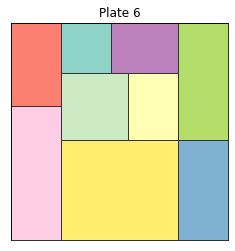

Instance[6] solved in 0.592 s, height: 13


Instance: n=9 w=14 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

>Starting Lower Bound: 14
>Starting Upper Bound: 17
	>Trying H:15
		>SAT - ub: 15, 0.29999566078186035 s
	>Trying H:14
		>SAT - ub: 14, 0.5870263576507568 s


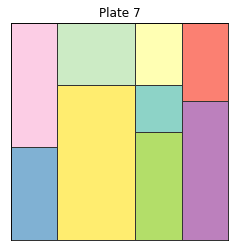

Instance[7] solved in 0.587 s, height: 14


Instance: n=10 w=15 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

>Starting Lower Bound: 15
>Starting Upper Bound: 17
	>Trying H:16
		>SAT - ub: 16, 0.3680388927459717 s
	>Trying H:15
		>SAT - ub: 15, 0.7320339679718018 s


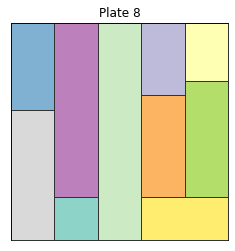

Instance[8] solved in 0.732 s, height: 15


Instance: n=10 w=16 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

>Starting Lower Bound: 16
>Starting Upper Bound: 19
	>Trying H:17
		>SAT - ub: 17, 0.3950541019439697 s
	>Trying H:16
		>SAT - ub: 16, 0.7840976715087891 s


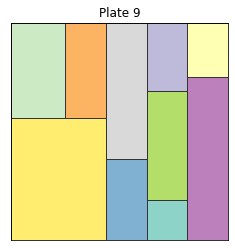

Instance[9] solved in 0.784 s, height: 16


Instance: n=12 w=17 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

>Starting Lower Bound: 17
>Starting Upper Bound: 18
	>Trying H:17
		>SAT - ub: 17, 0.6585252285003662 s


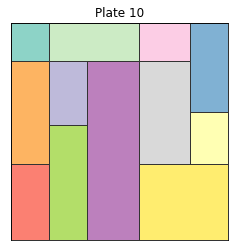

Instance[10] solved in 0.659 s, height: 17


Instance: n=16 w=18 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]

>Starting Lower Bound: 18
>Starting Upper Bound: 23
	>Trying H:20
		>SAT - ub: 20, 1.414182186126709 s
	>Trying H:19
		>SAT - ub: 19, 2.7854864597320557 s
	>Trying H:18
		>SAT - ub: 18, 4.1857383251190186 s


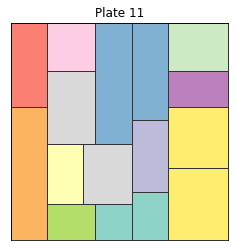

Instance[11] solved in 4.186 s, height: 18


Instance: n=14 w=19 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

>Starting Lower Bound: 19
>Starting Upper Bound: 23
	>Trying H:21
		>SAT - ub: 21, 1.038637638092041 s
	>Trying H:20
		>SAT - ub: 20, 2.1022796630859375 s
	>Trying H:19
		>SAT - ub: 19, 3.116347551345825 s


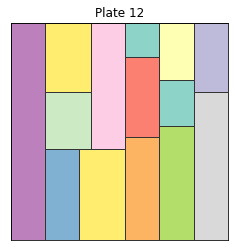

Instance[12] solved in 3.117 s, height: 19


Instance: n=14 w=20 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

>Starting Lower Bound: 20
>Starting Upper Bound: 24
	>Trying H:22
		>SAT - ub: 22, 1.10312819480896 s
	>Trying H:21
		>SAT - ub: 21, 2.149195671081543 s
	>Trying H:20
		>SAT - ub: 20, 3.1944427490234375 s


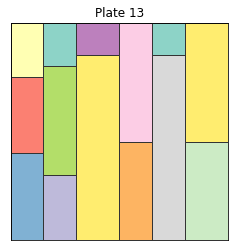

Instance[13] solved in 3.194 s, height: 20


Instance: n=15 w=21 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

>Starting Lower Bound: 21
>Starting Upper Bound: 25
	>Trying H:23
		>SAT - ub: 23, 1.3278429508209229 s
	>Trying H:22
		>SAT - ub: 22, 2.610595941543579 s
	>Trying H:21
		>SAT - ub: 21, 3.9490959644317627 s


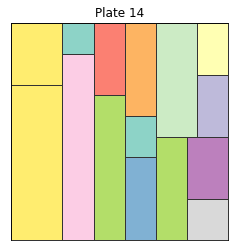

Instance[14] solved in 3.949 s, height: 21


Instance: n=16 w=22 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

>Starting Lower Bound: 22
>Starting Upper Bound: 24
	>Trying H:23
		>SAT - ub: 23, 1.4952905178070068 s
	>Trying H:22
		>SAT - ub: 22, 2.932650089263916 s


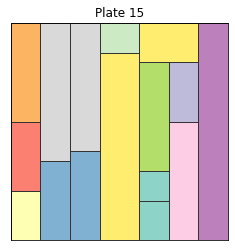

Instance[15] solved in 2.934 s, height: 22


Instance: n=19 w=23 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]

>Starting Lower Bound: 23
>Starting Upper Bound: 27
	>Trying H:25
		>SAT - ub: 25, 2.503742218017578 s
	>Trying H:24
		>SAT - ub: 24, 4.886324167251587 s
	>Trying H:23
		>SAT - ub: 23, 7.7972729206085205 s


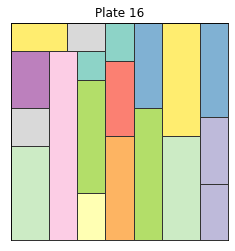

Instance[16] solved in 7.798 s, height: 23


Instance: n=18 w=24 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

>Starting Lower Bound: 24
>Starting Upper Bound: 28
	>Trying H:26
		>SAT - ub: 26, 2.1461899280548096 s
	>Trying H:25
		>SAT - ub: 25, 4.348102807998657 s
	>Trying H:24
		>SAT - ub: 24, 6.501140832901001 s


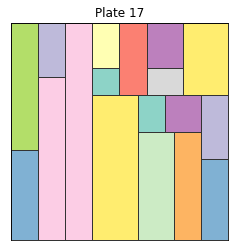

Instance[17] solved in 6.501 s, height: 24


Instance: n=19 w=25 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]

>Starting Lower Bound: 25
>Starting Upper Bound: 29
	>Trying H:27
		>SAT - ub: 27, 2.529315948486328 s
	>Trying H:26
		>SAT - ub: 26, 5.072140455245972 s
	>Trying H:25
		>SAT - ub: 25, 7.547877073287964 s


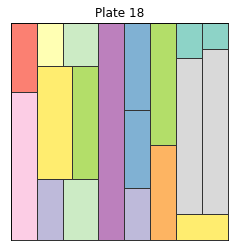

Instance[18] solved in 7.548 s, height: 25


Instance: n=22 w=26 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

>Starting Lower Bound: 26
>Starting Upper Bound: 30
	>Trying H:28
		>SAT - ub: 28, 3.732449531555176 s
	>Trying H:27
		>SAT - ub: 27, 7.315483331680298 s
	>Trying H:26
		>SAT - ub: 26, 11.436305046081543 s


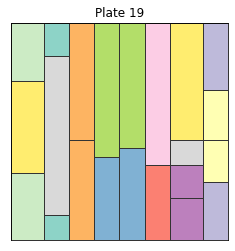

Instance[19] solved in 11.437 s, height: 26


Instance: n=21 w=27 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]

>Starting Lower Bound: 27
>Starting Upper Bound: 30
	>Trying H:28
		>SAT - ub: 28, 3.234504222869873 s
	>Trying H:27
		>SAT - ub: 27, 12.150785207748413 s


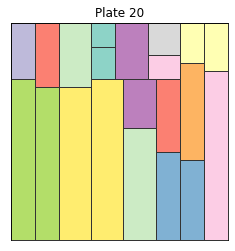

Instance[20] solved in 12.151 s, height: 27


Instance: n=22 w=28 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]

>Starting Lower Bound: 28
>Starting Upper Bound: 33
	>Trying H:30
		>SAT - ub: 30, 3.9753823280334473 s
	>Trying H:29
		>SAT - ub: 29, 8.291057825088501 s
	>Trying H:28
		>SAT - ub: 28, 17.279874563217163 s


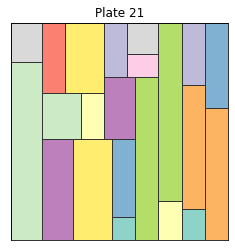

Instance[21] solved in 17.28 s, height: 28


Instance: n=24 w=29 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]

>Starting Lower Bound: 29
>Starting Upper Bound: 31
	>Trying H:30
		>SAT - ub: 30, 6.658210039138794 s
	>Trying H:29
		>SAT - ub: 29, 23.890425443649292 s


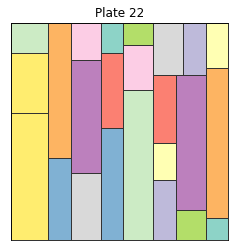

Instance[22] solved in 23.89 s, height: 29


Instance: n=20 w=30 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]

>Starting Lower Bound: 30
>Starting Upper Bound: 35
	>Trying H:32
		>SAT - ub: 32, 3.4244964122772217 s
	>Trying H:31
		>SAT - ub: 31, 6.8680102825164795 s
	>Trying H:30
		>SAT - ub: 30, 10.57445478439331 s


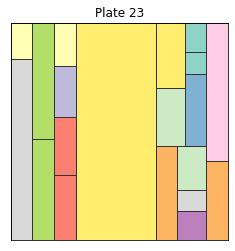

Instance[23] solved in 10.574 s, height: 30


Instance: n=19 w=31 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]

>Starting Lower Bound: 31
>Starting Upper Bound: 35
	>Trying H:33
		>SAT - ub: 33, 3.1211884021759033 s
	>Trying H:32
		>SAT - ub: 32, 6.154994010925293 s
	>Trying H:31
		>SAT - ub: 31, 9.125614166259766 s


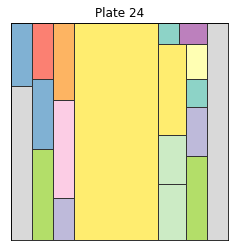

Instance[24] solved in 9.126 s, height: 31


Instance: n=27 w=32 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]

>Starting Lower Bound: 32
>Starting Upper Bound: 37
	>Trying H:34
		>SAT - ub: 34, 6.556341648101807 s
	>Trying H:33
		>SAT - ub: 33, 13.472233772277832 s
	>Trying H:32
		>SAT - ub: 32, 22.351454257965088 s


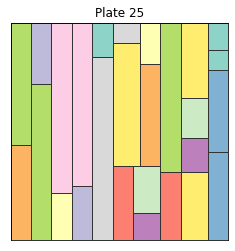

Instance[25] solved in 22.351 s, height: 32


Instance: n=23 w=33 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]

>Starting Lower Bound: 33
>Starting Upper Bound: 37
	>Trying H:35
		>SAT - ub: 35, 5.153354644775391 s
	>Trying H:34
		>SAT - ub: 34, 9.76016902923584 s
	>Trying H:33
		>SAT - ub: 33, 22.35457158088684 s


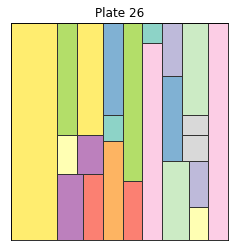

Instance[26] solved in 22.355 s, height: 33


Instance: n=21 w=34 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]

>Starting Lower Bound: 34
>Starting Upper Bound: 36
	>Trying H:35
		>SAT - ub: 35, 6.385293483734131 s
	>Trying H:34
		>SAT - ub: 34, 13.561352014541626 s


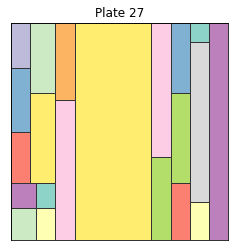

Instance[27] solved in 13.561 s, height: 34


Instance: n=22 w=35 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]

>Starting Lower Bound: 35
>Starting Upper Bound: 38
	>Trying H:36
		>SAT - ub: 36, 4.803625583648682 s
	>Trying H:35
		>SAT - ub: 35, 10.293471813201904 s


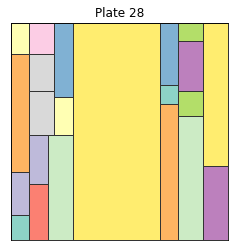

Instance[28] solved in 10.293 s, height: 35


Instance: n=23 w=36 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]

>Starting Lower Bound: 36
>Starting Upper Bound: 38
	>Trying H:37
		>SAT - ub: 37, 5.098250150680542 s
	>Trying H:36
		>SAT - ub: 36, 15.024683475494385 s


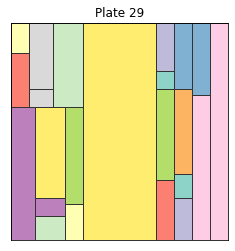

Instance[29] solved in 15.025 s, height: 36


Instance: n=27 w=37 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]

>Starting Lower Bound: 37
>Starting Upper Bound: 42
	>Trying H:39
		>SAT - ub: 39, 8.078880548477173 s
	>Trying H:38
		>SAT - ub: 38, 20.587504386901855 s
	>Trying H:37
		>SAT - ub: 37, 45.95099186897278 s


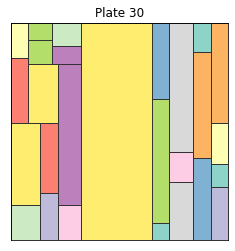

Instance[30] solved in 45.951 s, height: 37


Instance: n=19 w=38 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]

>Starting Lower Bound: 38
>Starting Upper Bound: 43
	>Trying H:40
		>SAT - ub: 40, 3.9756696224212646 s
	>Trying H:39
		>SAT - ub: 39, 8.149717569351196 s
	>Trying H:38
		>SAT - ub: 38, 12.788305521011353 s


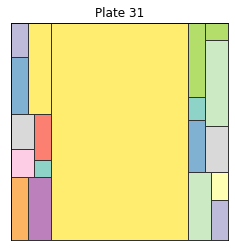

Instance[31] solved in 12.788 s, height: 38


Instance: n=29 w=39 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]

	>Trying H:41
		SAT - ub: 41, 10.322980642318726 s
	>Trying H:40
		SAT - ub: 40, 23.490936279296875 s
	>Trying H:39
		SAT - ub: 39, 112.8086998462677 s


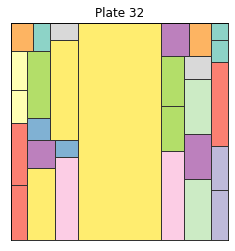

Instance[32] solved in 112.809 s, height: 39


Instance: n=20 w=40 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]

>Starting Lower Bound: 40
>Starting Upper Bound: 44
	>Trying H:42
		>SAT - ub: 42, 4.561250925064087 s
	>Trying H:41
		>SAT - ub: 41, 9.025837182998657 s
	>Trying H:40
		>SAT - ub: 40, 13.638895988464355 s


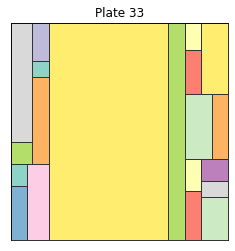

Instance[33] solved in 13.639 s, height: 40


Instance: n=25 w=15 dim=[[3, 11], [3, 13], [2, 9], [2, 7], [3, 9], [3, 7], [2, 11], [2, 13], [4, 11], [4, 13], [5, 3], [2, 11], [2, 2], [3, 11], [3, 2], [4, 5], [4, 6], [2, 12], [2, 1], [5, 3], [5, 13], [4, 12], [4, 1], [2, 5], [2, 6]]

>Starting Lower Bound: 40
>Starting Upper Bound: 44
	>Trying H:42
		>SAT - ub: 42, 5.269867181777954 s
	>Trying H:41
		>SAT - ub: 41, 10.50619387626648 s
	>Trying H:40
		>SAT - ub: 40, 17.434618949890137 s


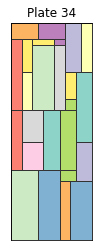

Instance[34] solved in 17.435 s, height: 40


Instance: n=25 w=15 dim=[[2, 11], [3, 2], [7, 10], [4, 8], [5, 9], [2, 7], [1, 4], [1, 6], [5, 4], [3, 8], [3, 1], [5, 5], [1, 3], [4, 12], [2, 6], [4, 2], [4, 11], [2, 10], [2, 3], [2, 11], [4, 3], [4, 26], [4, 8], [2, 3], [2, 6]]

>Starting Lower Bound: 40
>Starting Upper Bound: 42
	>Trying H:41
		>SAT - ub: 41, 5.210022687911987 s
	>Trying H:40
		>SAT - ub: 40, 19.85274600982666 s


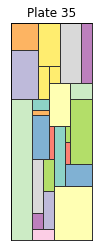

Instance[35] solved in 19.853 s, height: 40


Instance: n=25 w=15 dim=[[7, 12], [7, 7], [1, 7], [1, 5], [2, 3], [2, 6], [2, 7], [2, 5], [1, 3], [1, 6], [6, 12], [6, 9], [2, 12], [2, 7], [3, 10], [1, 4], [1, 5], [3, 16], [3, 5], [2, 4], [2, 5], [3, 10], [3, 9], [3, 16], [3, 5]]

>Starting Lower Bound: 40
>Starting Upper Bound: 44
	>Trying H:42
		>SAT - ub: 42, 5.321675777435303 s
	>Trying H:41
		>SAT - ub: 41, 11.29989218711853 s
	>Trying H:40
		>SAT - ub: 40, 19.580957889556885 s


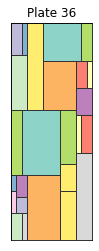

Instance[36] solved in 19.581 s, height: 40


Instance: n=28 w=30 dim=[[5, 7], [5, 14], [8, 14], [8, 4], [13, 21], [11, 7], [11, 14], [5, 14], [5, 4], [3, 18], [3, 21], [11, 17], [11, 4], [4, 7], [4, 5], [7, 6], [5, 18], [5, 3], [3, 7], [3, 5], [4, 18], [4, 3], [2, 12], [2, 6], [5, 18], [5, 21], [3, 17], [3, 4]]

>Starting Lower Bound: 60
>Starting Upper Bound: 66
	>Trying H:63
		>SAT - ub: 63, 10.864861011505127 s
	>Trying H:61
		>SAT - ub: 61, 32.35889029502869 s
	>Trying H:60
		>SAT - ub: 60, 111.16293430328369 s


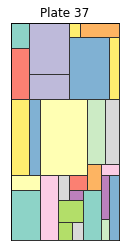

Instance[37] solved in 111.163 s, height: 60


Instance: n=29 w=30 dim=[[6, 18], [2, 12], [10, 7], [4, 23], [4, 1], [7, 7], [11, 4], [6, 5], [2, 7], [6, 11], [10, 19], [11, 5], [4, 2], [7, 5], [4, 2], [7, 12], [7, 13], [3, 6], [6, 10], [9, 16], [1, 4], [4, 10], [6, 24], [9, 9], [2, 1], [8, 5], [3, 5], [7, 25], [5, 21]]

>Starting Lower Bound: 60
>Starting Upper Bound: 65
	>Trying H:62
		>SAT - ub: 62, 11.773657083511353 s
	>Trying H:61
		>SAT - ub: 61, 23.4824161529541 s
	>Trying H:60
		>SAT - ub: 60, 245.60415148735046 s


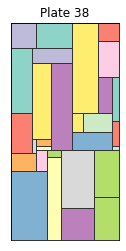

Instance[38] solved in 245.605 s, height: 60


Instance: n=28 w=30 dim=[[9, 24], [9, 8], [9, 11], [9, 17], [4, 24], [4, 8], [1, 6], [1, 5], [4, 17], [3, 6], [3, 5], [12, 5], [12, 13], [14, 14], [2, 14], [2, 2], [8, 3], [8, 9], [12, 14], [12, 2], [6, 3], [6, 9], [2, 5], [2, 13], [3, 18], [3, 14], [3, 16], [3, 12]]

>Starting Lower Bound: 60
>Starting Upper Bound: 67
	>Trying H:63
		>SAT - ub: 63, 10.83782148361206 s
	>Trying H:61
		>SAT - ub: 61, 21.664851427078247 s
	>Trying H:60
		>SAT - ub: 60, 45.10994100570679 s


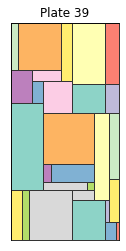

Instance[39] solved in 45.11 s, height: 60


Instance: n=73 w=60 dim=[[34, 6], [13, 3], [13, 5], [10, 12], [10, 12], [6, 7], [6, 15], [25, 7], [25, 15], [21, 12], [16, 7], [16, 5], [21, 3], [21, 5], [5, 7], [5, 5], [4, 1], [4, 10], [6, 13], [12, 13], [12, 9], [23, 6], [7, 3], [7, 5], [2, 1], [2, 10], [6, 6], [6, 5], [14, 7], [14, 6], [16, 3], [16, 5], [14, 6], [14, 5], [14, 13], [3, 2], [3, 7], [11, 2], [11, 7], [6, 7], [6, 6], [33, 14], [12, 4], [12, 3], [16, 18], [12, 3], [12, 18], [4, 4], [4, 3], [3, 1], [3, 2], [6, 9], [6, 9], [6, 1], [6, 2], [5, 7], [5, 18], [3, 9], [3, 9], [9, 18], [6, 5], [6, 2], [2, 12], [2, 9], [8, 3], [8, 9], [10, 9], [3, 5], [3, 2], [3, 18], [3, 7], [2, 3], [2, 9]]

>Starting Lower Bound: 90
>Starting Upper Bound: 96
	>Trying H:93
		>SAT - ub: 93, 130.6227035522461 s
	>Trying H:91
		>SAT - ub: 91, 269.1408152580261 s
	>Trying H:90


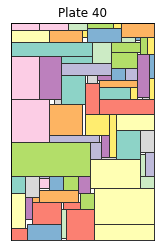

>Out of time, 423.956 s, best height: 91




In [6]:
from_ins = 1
to_ins   = 40

times = []
for ins in range(from_ins, min(to_ins+1,41)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    sol,e_time = vlsi_sat(instance)
    
    times.append(round(e_time,3))
    if sol is None and e_time <= 300:
        print(">Unfeasible.")
    elif e_time > 300:
        if sol is not None:
            # Write to file
            utils.writeSolution('./out/no_rot/out-' + str(ins) + '_non_opt.txt', sol)

            # Display solution
            utils.displaySolution(sol, title= f'Plate {ins}')

            print(f">Out of time, {round(e_time,3)} s, best height: {sol[0][1]}")
        else:
            print(f">Out of time, {round(e_time,3)} s")
    elif sol is not None:
        # Write to file
        utils.writeSolution('./out/no_rot/out-' + str(ins) + '.txt', sol)

        # Display solution
        utils.displaySolution(sol, title= f'Plate {ins}')
        
        # Time
        print(f"Instance[{ins}] solved in {round(e_time,3)} s, height: {sol[0][1]}")
    print('========================================================================================')
    print('\n')

with open('./out/times.txt', 'w+') as f:
    for i in range(from_ins, min(to_ins+1,41)):
            f.write('{}\n'.format(times[i-from_ins]))

### Export to .csv

In [12]:
from_ins = 1
to_ins   = 40

times = open("./out/times.txt").readlines()

with open('./out/vlsi_SAT.csv', 'w') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(['Instance', 'Time', 'Solution'])
    for ins in range(from_ins, min(to_ins+1,41)):
        row = []
        if float(times[ins-1]) <= 300.0:
            sol = utils.readSolution('./out/no_rot/out-' + str(ins) + '.txt' )
            if sol is not None:
                row = [str(ins), float(times[ins-1]), str(utils.readSolution('./report/outputs/out-' + str(ins) + '.txt'))]
            else:
                row = [str(ins), float(times[ins-1])] 
            writer.writerow(row)
        else:
            sol = utils.readSolution('./out/no_rot/out-' + str(ins) + '_non_opt.txt')
            if sol is not None:
                row = [str(ins), float(times[ins-1]), str(utils.readSolution('./report/outputs/out-' + str(ins) + '_non_opt.txt'))]
            else:
                row = [str(ins), float(times[ins-1])]
            writer.writerow(row)

f.close()

### Model with rotations

In [3]:
def vlsi_sat_rotations(instance):
    
    ''' VARIABLES '''

    n = instance['n']
    W = instance['w']
    widths  = [i[0] for i in instance['dim']]
    heights = [i[1] for i in instance['dim']]
    largest_idx = [w*h for w,h in zip(widths,heights)].index(max([w*h for w,h in\
                                                                        zip(widths,heights)]))   
    tot_area=sum([w*h for w,h in zip(widths,heights)])
    model = None
    
    naiveSolution = utils.computeNaiveSolution(instance)
    
    if not naiveSolution:
        return None

    lb = int(math.ceil(tot_area/W))
    ub = naiveSolution[0][1]+1
    
    print("\n>Starting Lower Bound:", lb)
    print(">Starting Upper Bound:", ub)
    
    H = int((lb+ub)/2)
    
    s_time = time.time()
    
    while (lb < ub):
        ''' SOLVER WITH 5 MINUTES TIMEOUT'''
        s = Solver()

        s.set("timeout", int((300-(time.time()-s_time))*1000))

        if (time.time() > s_time + 300):
            break
        else:
            print(f"\t>Trying H:{H}")
            
        '''
        ==================================================================
        The variable "f" points wether a component is flipped or not.
        ==================================================================
        '''
        px = [[Bool(f"px{i+1}_{x}") for x in range(W)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        py = [[Bool(f"py{i+1}_{y}") for y in range(H)] for i in range(n)] # x[i][i]: block i has y coordinate <=j
        lr = [[Bool(f"lr_{i+1}_{j+1}") if j!=i else 0 for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)]
        f = [Bool(f"f{i+1}") for i in range(n)] # f[i]: block i is flipped

        # Exactly One constraint
        for i in range(n): 
            '''
            ==================================================================
            Ranges of each component change depending on "f".
            ==================================================================
            '''
            if largest_rectangle(i, largest_idx):
                s.add(Or(
                        And (Not(f[i]), And([px[i][e] for e in range(int((W-widths[i])/2),W)])),
                        And ( f[i],      And([px[i][e] for e in range(int((W-heights[i])/2),W)]))
                    )) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 

                s.add(Or(
                    And (Not(f[i]), And([py[i][f] for f in range(int((H-heights[i])/2),H)])),
                    And (f[i],      And([py[i][f] for f in range(int((H-widths[i])/2),H)]))
                    ))
                    # same for the y coordinate 
            else:
                s.add(Or(
                        And (Not(f[i]), And([px[i][e] for e in range(W-widths[i],W)])),
                        And ( f[i],      And([px[i][e] for e in range(W-heights[i],W)]))
                    )) # block i starts for sure before position W-wi-> x[i][j]=True for all j > W-wi 

                s.add(Or(
                    And (Not(f[i]), And([py[i][f] for f in range(H-heights[i],H)])),
                    And (f[i],      And([py[i][f] for f in range(H-widths[i],H)]))
                    ))
                    # same for the y coordinate  

            s.add([Or(Not(px[i][e]),px[i][e+1]) for e in range(W-1)]) #x[i][j] implies x[i][j+1]
            s.add([Or(Not(py[i][f]),py[i][f+1]) for f in range(H-1)]) #y[i][j] implies y[i][j+1]

            for j in range(n):
                '''
                ==================================================================
                We must take in account the four possible orientations of
                two components.
                ==================================================================
                '''
                wi,wj,hi,hj=widths[i],widths[j],heights[i],heights[j]    
                cts=[] 
                if i<j:
                    if large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == False:
                            if same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                                s.add(Or(lr[i][j],ud[i][j],ud[j][i]))
                                
                                if wi<=W and hi<=H and wj<=W and hj<=H: 
                                    cts.append(And(Not(f[i]),Not(f[j]),
                                                   *no_overlap(W,H,widths,heights,\
                                                                        i,j,False,px,py,lr,ud),
                                                   *no_overlap(W,H,widths,heights,\
                                                                        j,i,False,px,py,False,ud),
                                                  ))
                                if wi<=H and hi<=W and wj<=W and hj<=H:
                                    cts.append(And(f[i],Not(f[j]),
                                                   *no_overlap(W,H,widths,heights,\
                                                                        i,j,True,px,py,lr,ud),
                                                   *no_overlap(W,H,widths,heights,\
                                                                        j,i,False,px,py,False,ud),
                                                  ))
                                if wi<=W and hi<=H and wj<=H and hj<=W:                        
                                    cts.append(And(Not(f[i]),f[j],
                                                   *no_overlap(W,H,widths,heights,\
                                                                        i,j,False,px,py,lr,ud),
                                                   *no_overlap(W,H,widths,heights,\
                                                                        j,i,True,px,py,False,ud),
                                                  ))
                                if wi<=H and hi<=W and wj<=H and hj<=W:                        
                                    cts.append(And(f[i],f[j],
                                                   *no_overlap(W,H,widths,heights,\
                                                                        i,j,True,px,py,lr,ud),
                                                   *no_overlap(W,H,widths,heights,\
                                                                        j,i,True,px,py,False,ud),
                                                  ))
                                s.add(Or(cts))

                                s.add(Or(
                                        Not(ud[i][j]),
                                        lr[j][i]
                                ))
                            else:
                                if not largest_rectangle(j, largest_idx):
                                    s.add(Or(lr[i][j],lr[j][i],ud[i][j],ud[j][i]))     
                                    
                                    if wi<=W and hi<=H and wj<=W and hj<=H: 
                                        cts.append(And(Not(f[i]),Not(f[j]),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            i,j,False,px,py,lr,ud),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            j,i,False,px,py,lr,ud),
                                                      ))
                                    if wi<=H and hi<=W and wj<=W and hj<=H:
                                        cts.append(And(f[i],Not(f[j]),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            i,j,True,px,py,lr,ud),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            j,i,False,px,py,lr,ud),
                                                      ))
                                    if wi<=W and hi<=H and wj<=H and hj<=W:                        
                                        cts.append(And(Not(f[i]),f[j],
                                                       *no_overlap(W,H,widths,heights,\
                                                                            i,j,False,px,py,lr,ud),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            j,i,True,px,py,lr,ud),
                                                      ))
                                    if wi<=H and hi<=W and wj<=H and hj<=W:                        
                                        cts.append(And(f[i],f[j],
                                                       *no_overlap(W,H,widths,heights,\
                                                                            i,j,True,px,py,lr,ud),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            j,i,True,px,py,lr,ud),
                                                      ))
                                    s.add(Or(cts))
                                else:
                                    s.add(Or(lr[j][i],ud[i][j],ud[j][i]))
                                    
                                    if wi<=W and hi<=H and wj<=W and hj<=H: 
                                        cts.append(And(Not(f[i]),Not(f[j]),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            i,j,False,px,py,False,ud),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            j,i,False,px,py,lr,ud),
                                                      ))
                                    if wi<=H and hi<=W and wj<=W and hj<=H:
                                        cts.append(And(f[i],Not(f[j]),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            i,j,True,px,py,False,ud),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            j,i,False,px,py,lr,ud),
                                                      ))
                                    if wi<=W and hi<=H and wj<=H and hj<=W:                        
                                        cts.append(And(Not(f[i]),f[j],
                                                       *no_overlap(W,H,widths,heights,\
                                                                            i,j,False,px,py,False,ud),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            j,i,True,px,py,lr,ud),
                                                      ))
                                    if wi<=H and hi<=W and wj<=H and hj<=W:                        
                                        cts.append(And(f[i],f[j],
                                                       *no_overlap(W,H,widths,heights,\
                                                                            i,j,True,px,py,False,ud),
                                                       *no_overlap(W,H,widths,heights,\
                                                                            j,i,True,px,py,lr,ud),
                                                      ))
                                    s.add(Or(cts))
                                    
                    elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "W":
                        s.add(Or(lr[j][i],ud[i][j],ud[j][i]))

                        if wi<=W and hi<=H and wj<=W and hj<=H: 
                            cts.append(And(Not(f[i]),Not(f[j]),
                                           *no_overlap(W,H,widths,heights,\
                                                                i,j,False,px,py,False,ud),
                                           *no_overlap(W,H,widths,heights,\
                                                                j,i,False,px,py,lr,ud),
                                          ))
                        if wi<=H and hi<=W and wj<=W and hj<=H:
                            cts.append(And(f[i],Not(f[j]),
                                           *no_overlap(W,H,widths,heights,\
                                                                i,j,True,px,py,False,ud),
                                           *no_overlap(W,H,widths,heights,\
                                                                j,i,False,px,py,lr,ud),
                                          ))
                        if wi<=W and hi<=H and wj<=H and hj<=W:                        
                            cts.append(And(Not(f[i]),f[j],
                                           *no_overlap(W,H,widths,heights,\
                                                                i,j,False,px,py,False,ud),
                                           *no_overlap(W,H,widths,heights,\
                                                                j,i,True,px,py,lr,ud),
                                          ))
                        if wi<=H and hi<=W and wj<=H and hj<=W:                        
                            cts.append(And(f[i],f[j],
                                           *no_overlap(W,H,widths,heights,\
                                                                i,j,True,px,py,False,ud),
                                           *no_overlap(W,H,widths,heights,\
                                                                j,i,True,px,py,lr,ud),
                                          ))
                        s.add(Or(cts))

                    elif large_rectangles(widths[i],widths[j],heights[i],heights[j], W, H) == "H":
                        if same_rectangles(widths[i],widths[j],heights[i],heights[j]):
                            s.add(lr[i][j])

                            if wi<=W and hi<=H and wj<=W and hj<=H: 
                                cts.append(And(Not(f[i]),Not(f[j]),
                                               *no_overlap(W,H,widths,heights,\
                                                                    i,j,False,px,py,lr,False)
                                              ))
                            if wi<=H and hi<=W and wj<=W and hj<=H:
                                cts.append(And(f[i],Not(f[j]),
                                               *no_overlap(W,H,widths,heights,\
                                                                    i,j,True,px,py,lr,False)
                                              ))
                            if wi<=W and hi<=H and wj<=H and hj<=W:                        
                                cts.append(And(Not(f[i]),f[j],
                                               *no_overlap(W,H,widths,heights,\
                                                                    i,j,False,px,py,lr,False)
                                              ))
                            if wi<=H and hi<=W and wj<=H and hj<=W:                        
                                cts.append(And(f[i],f[j],
                                               *no_overlap(W,H,widths,heights,\
                                                                    i,j,True,px,py,lr,False)
                                              ))
                            s.add(Or(cts))

                            s.add(Or(
                                    Not(ud[i][j]),
                                    lr[j][i]
                            ))  
                        else:                            
                            s.add(Or(lr[i][j],lr[j][i]))

                            if wi<=W and hi<=H and wj<=W and hj<=H: 
                                cts.append(And(Not(f[i]),Not(f[j]),
                                               *no_overlap(W,H,widths,heights,\
                                                                    i,j,False,px,py,lr,False),
                                               *no_overlap(W,H,widths,heights,\
                                                                    j,i,False,px,py,lr,False),
                                              ))
                            if wi<=H and hi<=W and wj<=W and hj<=H:
                                cts.append(And(f[i],Not(f[j]),
                                               *no_overlap(W,H,widths,heights,\
                                                                    i,j,True,px,py,lr,False),
                                               *no_overlap(W,H,widths,heights,\
                                                                    j,i,False,px,py,lr,False),
                                              ))
                            if wi<=W and hi<=H and wj<=H and hj<=W:                        
                                cts.append(And(Not(f[i]),f[j],
                                               *no_overlap(W,H,widths,heights,\
                                                                    i,j,False,px,py,lr,False),
                                               *no_overlap(W,H,widths,heights,\
                                                                    j,i,True,px,py,lr,False),
                                              ))
                            if wi<=H and hi<=W and wj<=H and hj<=W:                        
                                cts.append(And(f[i],f[j],
                                               *no_overlap(W,H,widths,heights,\
                                                                    i,j,True,px,py,lr,False),
                                               *no_overlap(W,H,widths,heights,\
                                                                    j,i,True,px,py,lr,False),
                                              ))
                            s.add(Or(cts))

        if s.check() == sat:
            if (time.time() - s_time <= 300):
                ub = H
                model = s.model()            
            
            print(f'\t\t>SAT - ub: {ub}, {time.time() - s_time} s')
            
        else:
            lb = H + 1
            if (time.time() - s_time <= 300):
                print(f'\t\t>UNSAT - lb: {lb}, {time.time() - s_time} s')

            
        H =  int((lb+ub)/2)
        
        '''
        ==================================================================
        'Bisection Method':
            while lb < ub
                o := (lb + ub)/2;
                result := Ψ ∪ {ph_o};
                if result is SAT
                    then ub := o;
                    else lb := o + 1;
            end while
        ==================================================================
        '''
    
    e_time = time.time() - s_time

    
    if model == None:
        return None, e_time
    elif e_time > 300:
        variables = { str(d):model.evaluate(model[d]) for d in model }
        cx,cy,widths,heights = getCoords(variables, W, ub, n, widths, heights, True)

        sol = [[W,ub]]+[[widths[i],heights[i],cx[i]+1,cy[i]+1]\
                    for i in range(min(len(cx),len(cy),len(widths),len(heights)))]
        
        return sol, e_time
    else:
        variables = { str(d):model.evaluate(model[d]) for d in model }
                
        cx,cy,widths,heights = getCoords(variables, W, H, n, widths, heights, True)
        sol=[[W,H]]+[[widths[i],heights[i],cx[i]+1,cy[i]+1] for i in range(n)]
        
        return sol, e_time


### Execution

Instance: n=4 w=8 dim=[[3, 3], [3, 5], [5, 3], [5, 5]]

>Starting Lower Bound: 8
>Starting Upper Bound: 9
	>Trying H:8
		>SAT - ub: 8, 0.1020352840423584 s


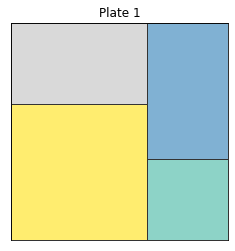

Instance[1] solved in 0.102 s, height: 8


Instance: n=5 w=9 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

>Starting Lower Bound: 9
>Starting Upper Bound: 10
	>Trying H:9
		>SAT - ub: 9, 0.16556119918823242 s


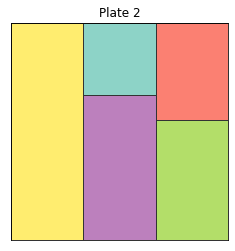

Instance[2] solved in 0.166 s, height: 9


Instance: n=6 w=10 dim=[[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

>Starting Lower Bound: 10
>Starting Upper Bound: 11
	>Trying H:10
		>SAT - ub: 10, 0.28258609771728516 s


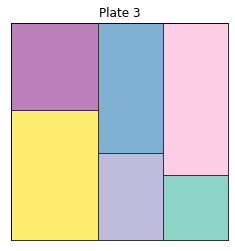

Instance[3] solved in 0.283 s, height: 10


Instance: n=7 w=11 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

>Starting Lower Bound: 11
>Starting Upper Bound: 13
	>Trying H:12
		>SAT - ub: 12, 0.6108126640319824 s
	>Trying H:11
		>SAT - ub: 11, 1.124110221862793 s


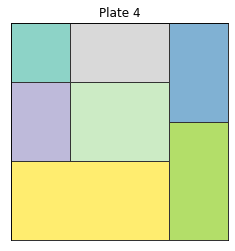

Instance[4] solved in 1.124 s, height: 11


Instance: n=8 w=12 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

>Starting Lower Bound: 12
>Starting Upper Bound: 15
	>Trying H:13
		>SAT - ub: 13, 0.6961500644683838 s
	>Trying H:12
		>SAT - ub: 12, 1.351442575454712 s


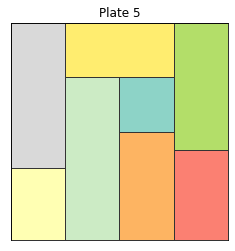

Instance[5] solved in 1.351 s, height: 12


Instance: n=9 w=13 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

>Starting Lower Bound: 13
>Starting Upper Bound: 16
	>Trying H:14
		>SAT - ub: 14, 1.078373670578003 s
	>Trying H:13
		>SAT - ub: 13, 2.1387200355529785 s


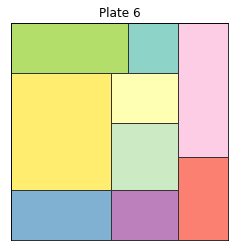

Instance[6] solved in 2.139 s, height: 13


Instance: n=9 w=14 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

>Starting Lower Bound: 14
>Starting Upper Bound: 17
	>Trying H:15
		>SAT - ub: 15, 1.1050431728363037 s
	>Trying H:14
		>SAT - ub: 14, 2.1506950855255127 s


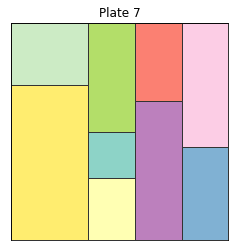

Instance[7] solved in 2.151 s, height: 14


Instance: n=10 w=15 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

>Starting Lower Bound: 15
>Starting Upper Bound: 17
	>Trying H:16
		>SAT - ub: 16, 1.425114393234253 s
	>Trying H:15
		>SAT - ub: 15, 2.7233822345733643 s


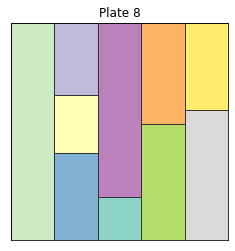

Instance[8] solved in 2.723 s, height: 15


Instance: n=10 w=16 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

>Starting Lower Bound: 16
>Starting Upper Bound: 19
	>Trying H:17
		>SAT - ub: 17, 1.496720552444458 s
	>Trying H:16
		>SAT - ub: 16, 3.01432728767395 s


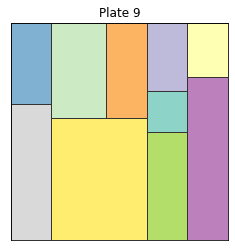

Instance[9] solved in 3.014 s, height: 16


Instance: n=12 w=17 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

>Starting Lower Bound: 17
>Starting Upper Bound: 18
	>Trying H:17
		>SAT - ub: 17, 3.1741976737976074 s


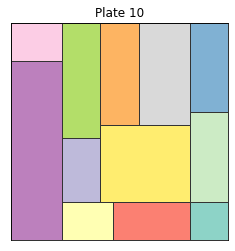

Instance[10] solved in 3.174 s, height: 17


Instance: n=16 w=18 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]

>Starting Lower Bound: 18
>Starting Upper Bound: 23
	>Trying H:20
		>SAT - ub: 20, 5.916274547576904 s
	>Trying H:19
		>SAT - ub: 19, 11.863030672073364 s
	>Trying H:18
		>SAT - ub: 18, 20.38983941078186 s


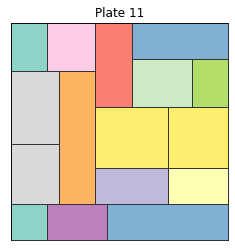

Instance[11] solved in 20.39 s, height: 18


Instance: n=14 w=19 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

>Starting Lower Bound: 19
>Starting Upper Bound: 23
	>Trying H:21
		>SAT - ub: 21, 4.435785531997681 s
	>Trying H:20
		>SAT - ub: 20, 8.643983364105225 s
	>Trying H:19
		>SAT - ub: 19, 13.395207405090332 s


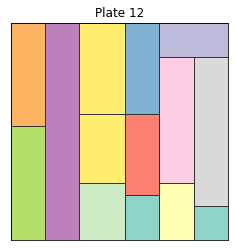

Instance[12] solved in 13.395 s, height: 19


Instance: n=14 w=20 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

>Starting Lower Bound: 20
>Starting Upper Bound: 24
	>Trying H:22
		>SAT - ub: 22, 4.4022722244262695 s
	>Trying H:21
		>SAT - ub: 21, 8.732599258422852 s
	>Trying H:20
		>SAT - ub: 20, 12.894737958908081 s


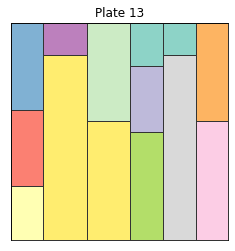

Instance[13] solved in 12.895 s, height: 20


Instance: n=15 w=21 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

>Starting Lower Bound: 21
>Starting Upper Bound: 25
	>Trying H:23
		>SAT - ub: 23, 5.213269233703613 s
	>Trying H:22
		>SAT - ub: 22, 10.508307218551636 s
	>Trying H:21
		>SAT - ub: 21, 16.21549963951111 s


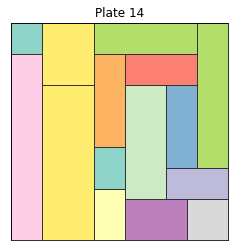

Instance[14] solved in 16.215 s, height: 21


Instance: n=16 w=22 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

>Starting Lower Bound: 22
>Starting Upper Bound: 24
	>Trying H:23
		>SAT - ub: 23, 5.993803977966309 s
	>Trying H:22
		>SAT - ub: 22, 11.904913187026978 s


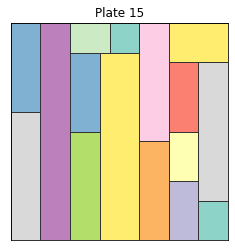

Instance[15] solved in 11.905 s, height: 22


Instance: n=19 w=23 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]

>Starting Lower Bound: 23
>Starting Upper Bound: 27
	>Trying H:25
		>SAT - ub: 25, 10.020632028579712 s
	>Trying H:24
		>SAT - ub: 24, 20.130241632461548 s
	>Trying H:23
		>SAT - ub: 23, 47.483298778533936 s


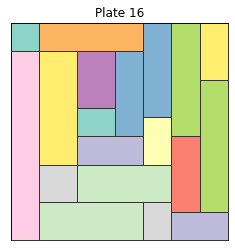

Instance[16] solved in 47.483 s, height: 23


Instance: n=18 w=24 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

>Starting Lower Bound: 24
>Starting Upper Bound: 28
	>Trying H:26
		>SAT - ub: 26, 8.937101602554321 s
	>Trying H:25
		>SAT - ub: 25, 18.01553225517273 s
	>Trying H:24
		>SAT - ub: 24, 32.26422739028931 s


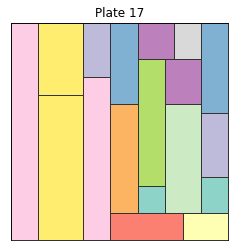

Instance[17] solved in 32.264 s, height: 24


Instance: n=19 w=25 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]

>Starting Lower Bound: 25
>Starting Upper Bound: 29
	>Trying H:27
		>SAT - ub: 27, 10.588695287704468 s
	>Trying H:26
		>SAT - ub: 26, 20.559701681137085 s
	>Trying H:25
		>SAT - ub: 25, 29.91584062576294 s


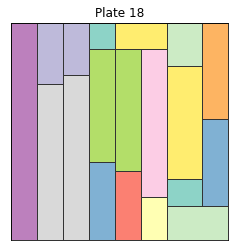

Instance[18] solved in 29.916 s, height: 25


Instance: n=22 w=26 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

>Starting Lower Bound: 26
>Starting Upper Bound: 30
	>Trying H:28
		>SAT - ub: 28, 15.418566703796387 s
	>Trying H:27
		>SAT - ub: 27, 31.165873527526855 s
	>Trying H:26
		>SAT - ub: 26, 85.95590662956238 s


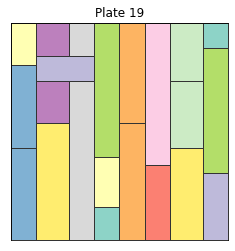

Instance[19] solved in 85.956 s, height: 26


Instance: n=21 w=27 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]

>Starting Lower Bound: 27
>Starting Upper Bound: 30
	>Trying H:28
		>SAT - ub: 28, 13.668162822723389 s
	>Trying H:27
		>SAT - ub: 27, 60.934775590896606 s


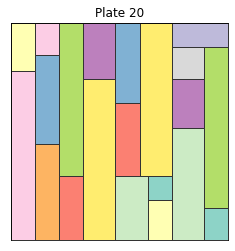

Instance[20] solved in 60.935 s, height: 27


Instance: n=22 w=28 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]

>Starting Lower Bound: 28
>Starting Upper Bound: 33
	>Trying H:30
		>SAT - ub: 30, 16.143773794174194 s
	>Trying H:29
		>SAT - ub: 29, 34.43636441230774 s
	>Trying H:28
		>SAT - ub: 28, 86.23331689834595 s


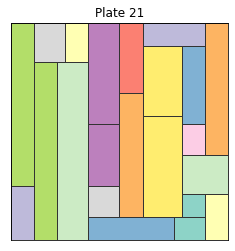

Instance[21] solved in 86.233 s, height: 28


Instance: n=24 w=29 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]

>Starting Lower Bound: 29
>Starting Upper Bound: 31
	>Trying H:30
		>SAT - ub: 30, 21.047972202301025 s
	>Trying H:29
		>SAT - ub: 29, 52.35702157020569 s


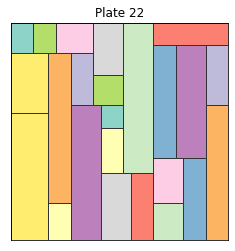

Instance[22] solved in 52.357 s, height: 29


Instance: n=20 w=30 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]

>Starting Lower Bound: 30
>Starting Upper Bound: 35
	>Trying H:32
		>SAT - ub: 32, 13.920169830322266 s
	>Trying H:31
		>SAT - ub: 31, 28.270694971084595 s
	>Trying H:30
		>SAT - ub: 30, 43.264163970947266 s


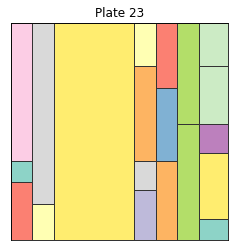

Instance[23] solved in 43.264 s, height: 30


Instance: n=19 w=31 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]

>Starting Lower Bound: 31
>Starting Upper Bound: 35
	>Trying H:33
		>SAT - ub: 33, 13.09238886833191 s
	>Trying H:32
		>SAT - ub: 32, 25.799649715423584 s
	>Trying H:31
		>SAT - ub: 31, 41.486568212509155 s


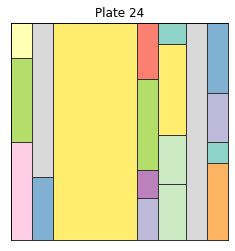

Instance[24] solved in 41.487 s, height: 31


Instance: n=27 w=32 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]

>Starting Lower Bound: 32
>Starting Upper Bound: 37
	>Trying H:34
		>SAT - ub: 34, 27.792964220046997 s
	>Trying H:33
		>SAT - ub: 33, 56.4465389251709 s
	>Trying H:32
		>SAT - ub: 32, 261.02997732162476 s


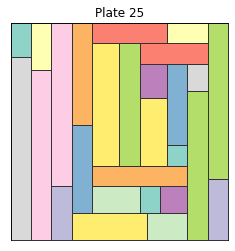

Instance[25] solved in 261.03 s, height: 32


Instance: n=23 w=33 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]

>Starting Lower Bound: 33
>Starting Upper Bound: 37
	>Trying H:35
		>SAT - ub: 35, 20.125359296798706 s
	>Trying H:34
		>SAT - ub: 34, 41.38580822944641 s
	>Trying H:33
		>SAT - ub: 33, 116.44255352020264 s


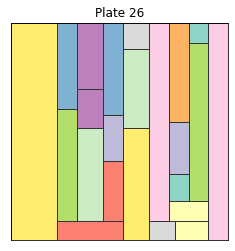

Instance[26] solved in 116.443 s, height: 33


Instance: n=21 w=34 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]

>Starting Lower Bound: 34
>Starting Upper Bound: 36
	>Trying H:35
		>SAT - ub: 35, 17.997284173965454 s
	>Trying H:34
		>SAT - ub: 34, 58.73641014099121 s


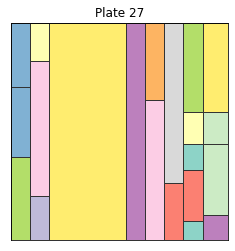

Instance[27] solved in 58.736 s, height: 34


Instance: n=22 w=35 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]

>Starting Lower Bound: 35
>Starting Upper Bound: 38
	>Trying H:36
		>SAT - ub: 36, 22.0640709400177 s
	>Trying H:35
		>SAT - ub: 35, 83.97952580451965 s


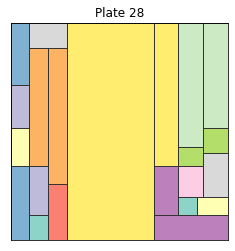

Instance[28] solved in 83.981 s, height: 35


Instance: n=23 w=36 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]

>Starting Lower Bound: 36
>Starting Upper Bound: 38
	>Trying H:37
		>SAT - ub: 37, 30.30711317062378 s
	>Trying H:36
		>SAT - ub: 36, 53.894455432891846 s


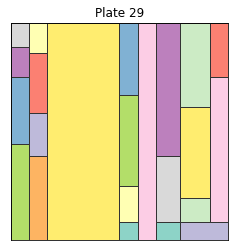

Instance[29] solved in 53.894 s, height: 36


Instance: n=27 w=37 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]

>Starting Lower Bound: 37
>Starting Upper Bound: 42
	>Trying H:39
		>SAT - ub: 39, 35.53533315658569 s
	>Trying H:38
		>SAT - ub: 38, 76.10888624191284 s
	>Trying H:37
		>SAT - ub: 37, 218.92535400390625 s


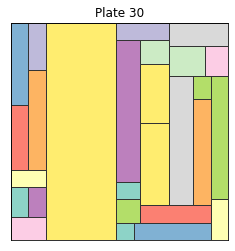

Instance[30] solved in 218.925 s, height: 37



Instance: n=19 w=38 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]

>Starting Lower Bound: 38
>Starting Upper Bound: 43
	>Trying H:40
		>SAT - ub: 40, 17.52886700630188 s
	>Trying H:39
		>SAT - ub: 39, 35.06673240661621 s
	>Trying H:38
		>SAT - ub: 38, 58.01451110839844 s


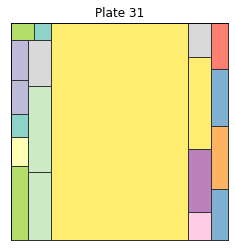

Instance[31] solved in 58.015 s, height: 38



Instance: n=29 w=39 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]

>Starting Lower Bound: 39
>Starting Upper Bound: 44
	>Trying H:41
		>SAT - ub: 41, 45.02544450759888 s
	>Trying H:40
		>SAT - ub: 40, 230.67177176475525 s
	>Trying H:39


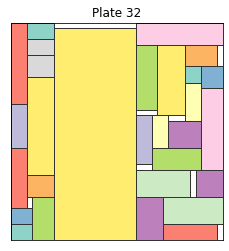

>Out of time, 339.534 s, best height: 40


Instance: n=20 w=40 dim=[[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]

>Starting Lower Bound: 40
>Starting Upper Bound: 44
	>Trying H:42
		>SAT - ub: 42, 21.6965594291687 s
	>Trying H:41
		>SAT - ub: 41, 45.02977752685547 s
	>Trying H:40
		>SAT - ub: 40, 76.12181758880615 s


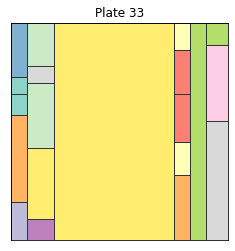

Instance[33] solved in 76.122 s, height: 40


Instance: n=25 w=15 dim=[[3, 11], [3, 13], [2, 9], [2, 7], [3, 9], [3, 7], [2, 11], [2, 13], [4, 11], [4, 13], [5, 3], [2, 11], [2, 2], [3, 11], [3, 2], [4, 5], [4, 6], [2, 12], [2, 1], [5, 3], [5, 13], [4, 12], [4, 1], [2, 5], [2, 6]]

>Starting Lower Bound: 40
>Starting Upper Bound: 44
	>Trying H:42
		>SAT - ub: 42, 23.53095030784607 s
	>Trying H:41
		>SAT - ub: 41, 46.24952745437622 s
	>Trying H:40
		>SAT - ub: 40, 74.60114574432373 s


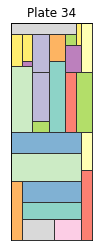

Instance[34] solved in 74.601 s, height: 40


Instance: n=25 w=15 dim=[[2, 11], [3, 2], [7, 10], [4, 8], [5, 9], [2, 7], [1, 4], [1, 6], [5, 4], [3, 8], [3, 1], [5, 5], [1, 3], [4, 12], [2, 6], [4, 2], [4, 11], [2, 10], [2, 3], [2, 11], [4, 3], [4, 26], [4, 8], [2, 3], [2, 6]]

>Starting Lower Bound: 40
>Starting Upper Bound: 42
	>Trying H:41
		>SAT - ub: 41, 22.114964962005615 s
	>Trying H:40
		>SAT - ub: 40, 47.17656087875366 s


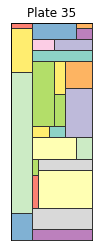

Instance[35] solved in 47.177 s, height: 40


Instance: n=25 w=15 dim=[[7, 12], [7, 7], [1, 7], [1, 5], [2, 3], [2, 6], [2, 7], [2, 5], [1, 3], [1, 6], [6, 12], [6, 9], [2, 12], [2, 7], [3, 10], [1, 4], [1, 5], [3, 16], [3, 5], [2, 4], [2, 5], [3, 10], [3, 9], [3, 16], [3, 5]]

>Starting Lower Bound: 40
>Starting Upper Bound: 44
	>Trying H:42
		>SAT - ub: 42, 22.164032220840454 s
	>Trying H:41
		>SAT - ub: 41, 43.18361473083496 s
	>Trying H:40
		>SAT - ub: 40, 66.73119068145752 s


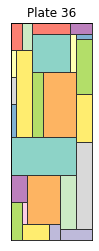

Instance[36] solved in 66.731 s, height: 40


Instance: n=28 w=30 dim=[[5, 7], [5, 14], [8, 14], [8, 4], [13, 21], [11, 7], [11, 14], [5, 14], [5, 4], [3, 18], [3, 21], [11, 17], [11, 4], [4, 7], [4, 5], [7, 6], [5, 18], [5, 3], [3, 7], [3, 5], [4, 18], [4, 3], [2, 12], [2, 6], [5, 18], [5, 21], [3, 17], [3, 4]]

>Starting Lower Bound: 60
>Starting Upper Bound: 66
	>Trying H:63
		>SAT - ub: 63, 47.642566204071045 s
	>Trying H:61
		>SAT - ub: 61, 103.1501362323761 s
	>Trying H:60


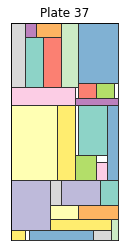

>Out of time, 342.636 s, best height: 61


Instance: n=29 w=30 dim=[[6, 18], [2, 12], [10, 7], [4, 23], [4, 1], [7, 7], [11, 4], [6, 5], [2, 7], [6, 11], [10, 19], [11, 5], [4, 2], [7, 5], [4, 2], [7, 12], [7, 13], [3, 6], [6, 10], [9, 16], [1, 4], [4, 10], [6, 24], [9, 9], [2, 1], [8, 5], [3, 5], [7, 25], [5, 21]]

>Starting Lower Bound: 60
>Starting Upper Bound: 65
	>Trying H:62
		>SAT - ub: 62, 53.22412967681885 s
	>Trying H:61
		>SAT - ub: 61, 105.81493616104126 s
	>Trying H:60


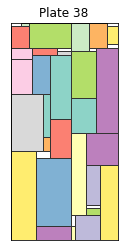

>Out of time, 346.435 s, best height: 61


Instance: n=28 w=30 dim=[[9, 24], [9, 8], [9, 11], [9, 17], [4, 24], [4, 8], [1, 6], [1, 5], [4, 17], [3, 6], [3, 5], [12, 5], [12, 13], [14, 14], [2, 14], [2, 2], [8, 3], [8, 9], [12, 14], [12, 2], [6, 3], [6, 9], [2, 5], [2, 13], [3, 18], [3, 14], [3, 16], [3, 12]]

>Starting Lower Bound: 60
>Starting Upper Bound: 67
	>Trying H:63
		>SAT - ub: 63, 48.556795597076416 s
	>Trying H:61
		>SAT - ub: 61, 109.19933652877808 s
	>Trying H:60


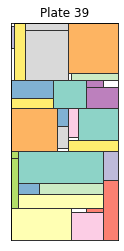

>Out of time, 343.154 s, best height: 61


Instance: n=73 w=60 dim=[[34, 6], [13, 3], [13, 5], [10, 12], [10, 12], [6, 7], [6, 15], [25, 7], [25, 15], [21, 12], [16, 7], [16, 5], [21, 3], [21, 5], [5, 7], [5, 5], [4, 1], [4, 10], [6, 13], [12, 13], [12, 9], [23, 6], [7, 3], [7, 5], [2, 1], [2, 10], [6, 6], [6, 5], [14, 7], [14, 6], [16, 3], [16, 5], [14, 6], [14, 5], [14, 13], [3, 2], [3, 7], [11, 2], [11, 7], [6, 7], [6, 6], [33, 14], [12, 4], [12, 3], [16, 18], [12, 3], [12, 18], [4, 4], [4, 3], [3, 1], [3, 2], [6, 9], [6, 9], [6, 1], [6, 2], [5, 7], [5, 18], [3, 9], [3, 9], [9, 18], [6, 5], [6, 2], [2, 12], [2, 9], [8, 3], [8, 9], [10, 9], [3, 5], [3, 2], [3, 18], [3, 7], [2, 3], [2, 9]]

>Starting Lower Bound: 90
>Starting Upper Bound: 104
	>Trying H:97
		>SAT - ub: 97, 592.8425495624542 s
	>Trying H:93


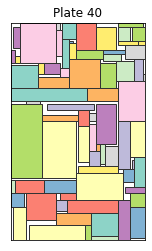

>Out of time, 593.292 s, best height: 97




In [19]:
from_ins = 1
to_ins   = 40

times_r = []
for ins in range(from_ins, min(to_ins+1,41)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    sol,e_time = vlsi_sat_rotations(instance)
    
    times_r.append(round(e_time,3))
    if sol is None and e_time <= 300:
        print(">Unfeasible.")
    elif e_time > 300:
        if sol is not None:
            # Write to file
            utils.writeSolution('./out/rot/out-' + str(ins) + '_non_opt.txt', sol)

            # Display solution
            utils.displaySolution(sol, title= f'Plate {ins}')


            print(f">Out of time, {round(e_time,3)} s, best height: {sol[0][1]}")
        else:
            print(f">Out of time, {round(e_time,3)} s")
    elif sol is not None:
        # Write to file
        utils.writeSolution('./out/rot/out-' + str(ins) + '.txt', sol)

        # Display solution
        utils.displaySolution(sol, title= f'Plate {ins}')
        
        # Time
        print(f"Instance[{ins}] solved in {round(e_time,3)} s, height: {sol[0][1]}")
    print('========================================================================================')
    print('\n')

with open('./out/times_r.txt', 'w+') as f:
    for i in range(from_ins, min(to_ins+1,41)):
            f.write('{}\n'.format(times_r[i-from_ins]))

In [4]:
from_ins = 40
to_ins   = 40

times_r = []
for ins in range(from_ins, min(to_ins+1,41)):
    print('========================================================================================')

    # Instance
    instance=utils.loadInstance(f"../instances/ins-{ins}.txt")
    print("Instance:",*["{}={}".format(key,val) for key,val in instance.items()])

    # Solving
    sol,e_time = vlsi_sat_rotations(instance)
    
    times_r.append(round(e_time,3))
    if sol is None and e_time <= 300:
        print(">Unfeasible.")
    elif e_time > 300:
        if sol is not None:
            # Write to file
            utils.writeSolution('./out/rot/out-' + str(ins) + '_non_opt2.txt', sol)

            # Display solution
            utils.displaySolution(sol, title= f'Plate {ins}')


            print(f">Out of time, {round(e_time,3)} s, best height: {sol[0][1]}")
        else:
            print(f">Out of time, {round(e_time,3)} s")
    elif sol is not None:
        # Write to file
        utils.writeSolution('./out/rot/out-' + str(ins) + '2.txt', sol)

        # Display solution
        utils.displaySolution(sol, title= f'Plate {ins}')
        
        # Time
        print(f"Instance[{ins}] solved in {round(e_time,3)} s, height: {sol[0][1]}")
    print('========================================================================================')
    print('\n')

with open('./out/times_r2.txt', 'w+') as f:
    for i in range(from_ins, min(to_ins+1,41)):
            f.write('{}\n'.format(times_r[i-from_ins]))

Instance: n=73 w=60 dim=[[34, 6], [13, 3], [13, 5], [10, 12], [10, 12], [6, 7], [6, 15], [25, 7], [25, 15], [21, 12], [16, 7], [16, 5], [21, 3], [21, 5], [5, 7], [5, 5], [4, 1], [4, 10], [6, 13], [12, 13], [12, 9], [23, 6], [7, 3], [7, 5], [2, 1], [2, 10], [6, 6], [6, 5], [14, 7], [14, 6], [16, 3], [16, 5], [14, 6], [14, 5], [14, 13], [3, 2], [3, 7], [11, 2], [11, 7], [6, 7], [6, 6], [33, 14], [12, 4], [12, 3], [16, 18], [12, 3], [12, 18], [4, 4], [4, 3], [3, 1], [3, 2], [6, 9], [6, 9], [6, 1], [6, 2], [5, 7], [5, 18], [3, 9], [3, 9], [9, 18], [6, 5], [6, 2], [2, 12], [2, 9], [8, 3], [8, 9], [10, 9], [3, 5], [3, 2], [3, 18], [3, 7], [2, 3], [2, 9]]

>Starting Lower Bound: 90
>Starting Upper Bound: 96
	>Trying H:93
		>SAT - ub: 96, 625.8992381095886 s
>Out of time, 626.409 s




### Export to .csv

In [33]:
from_ins = 1
to_ins   = 40

times_r = open("./out/times_r.txt").readlines()

with open('./out/vlsi_SAT_r.csv', 'w') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(['Instance', 'Time', 'Solution'])
    for ins in range(from_ins, min(to_ins+1,41)):
        row = []
        if float(times_r[ins-1]) <= 300.0:
            sol = utils.readSolution('./out/rot/out-' + str(ins) + '.txt' )
            if sol is not None:
                row = [str(ins), float(times_r[ins-1]), str(utils.readSolution('./out/rot/out-' + str(ins) + '.txt'))]
            else:
                row = [str(ins), float(times_r[ins-1])] 
            writer.writerow(row)
        else:
            sol = utils.readSolution('./out/rot/out-' + str(ins) + '_non_opt.txt')
            if sol is not None:
                row = [str(ins), float(times_r[ins-1]), str(utils.readSolution('./out/rot/out-' + str(ins) + '_non_opt.txt'))]
            else:
                row = [str(ins), float(times_r[ins-1])]
            writer.writerow(row)

f.close()

### Barplot

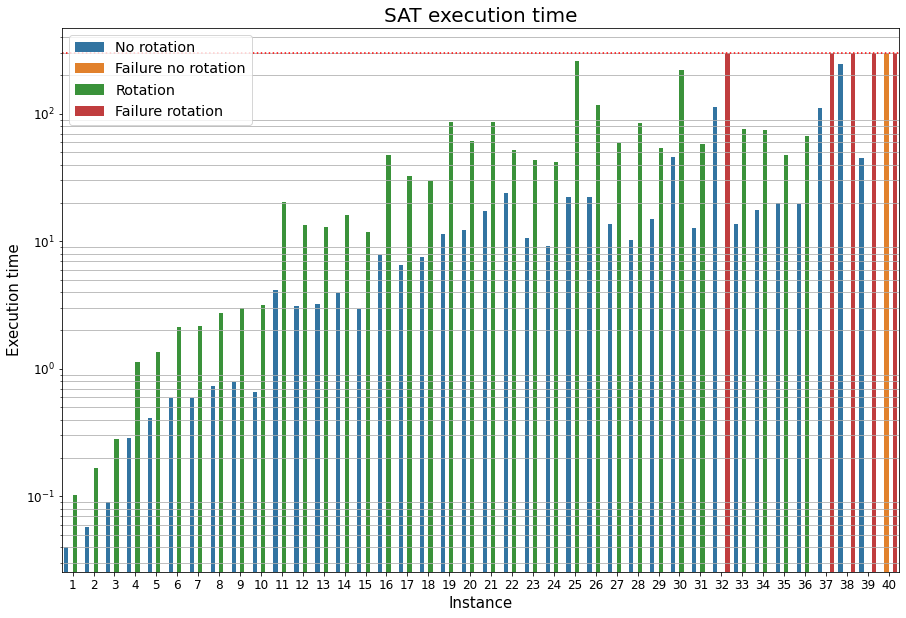

In [13]:
csv_no_rotation = './out/vlsi_SAT.csv'
csv_rotation = './out/vlsi_SAT_r.csv'

df = pd.read_csv(csv_no_rotation, sep=';')
df_flip = pd.read_csv(csv_rotation, sep=';')

df['mode'] = 'No rotation'
df_flip['mode'] = 'Rotation'

df.loc[df['Time'] > 300, 'mode']= 'Failure no rotation'
df_flip.loc[df_flip['Time'] > 300, 'mode']= 'Failure rotation'

df.loc[df['Time'] > 300, 'Time']= 300
df_flip.loc[df_flip['Time'] > 300, 'Time']= 300

df = pd.concat([df, df_flip])

sns.set_palette(sns.color_palette("tab10"))
plt.figure(figsize = (15,10))
sns.barplot(data = df, x = 'Instance', y = 'Time', hue = 'mode', hue_order=['No rotation', 'Failure no rotation'\
                                                                            ,'Rotation', 'Failure rotation'])

plt.xticks(fontsize = 'large')
plt.yticks(fontsize = 'large')
plt.xlabel('Instance', size = 15)
plt.ylabel('Execution time', size = 15)
plt.title('SAT execution time', size = 20)
plt.legend(loc = 'upper left', fontsize='x-large')

plt.yscale('log')
plt.grid(True, which="minor")

threshold = 300
plt.axhline(threshold, color='red', ls='dotted')

plt.savefig('./out/report_SAT.png', edgecolor='w', facecolor = 'w')
plt.show()